In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datadata import utils
from prevision import *
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from IPython.display import display


In [114]:
input_sequence_length=14
output_sequence_length=1
SCORING=0 # 0 for MSE, 1 for MAE
EVAL_METRIC=1
scoring_RCV = {0:'neg_mean_squared_error',1:'neg_mean_absolute_error'}[SCORING]
scoring_Ray={0:'rmse',1:'mae'}[SCORING]
eval_metric={0:'rmse',1:'mae'}[SCORING]
HOURLY=False
df_all,x,y=getAllDataFromCSV(hourly=HOURLY)

In [115]:
x.head()

,apparent_temperature_max,apparent_temperature_min,sunset,uv_index_max,rain_sum,showers_sum,snowfall_sum,precipitation_hours,attendance_concerts,attendance_conferences,...,day_3,day_4,day_5,day_6,vacance,ferie,match_mma,match_nba,match_nfl,match_nhl
date,,,,,,,,,,,,,,,,,,,,,
2023-09-15,20.1,8.0,19.10,5.40,0.00,0.0,0.0,0.0,0,0,...,False,True,False,False,0,False,0,0,0,0
2023-09-14,14.5,11.4,19.13,3.90,0.00,0.0,0.0,0.0,0,0,...,True,False,False,False,0,False,0,0,0,0
2023-09-13,23.4,15.2,19.17,4.75,36.75,0.0,0.0,4.0,0,0,...,False,False,False,False,0,False,1,0,0,0
2023-09-12,23.9,14.5,19.18,4.55,0.00,0.0,0.0,0.0,0,0,...,False,False,False,False,0,False,1,0,0,0
2023-09-11,23.4,15.5,19.22,5.65,0.00,0.0,0.0,0.0,0,0,...,False,False,False,False,0,False,0,0,0,0


In [116]:
y.head()

,vente
date,
2023-09-15,12222.69
2023-09-14,11244.54
2023-09-13,6514.32
2023-09-12,5708.35
2023-09-11,3031.55


In [117]:
class WindowGenerator():
    def __init__(self, X, Y, input_sequence_length=14, output_sequence_length=1):
        self.X=X
        self.Y=Y
        self.input_sequence_length = input_sequence_length
        self.output_sequence_length = output_sequence_length
        
        assert (len(self.X) - self.input_sequence_length - self.output_sequence_length + 1 > 0), \
            f'Dataset size too small for current options\ndata:{len(self.X)}, ' \
            f'input_sequence_length:{input_sequence_length}, output_sequence_length:{output_sequence_length}'

    def __len__(self):  # number of windows we can generate to work it must be at least 1
        return len(self.X) - self.input_sequence_length - self.output_sequence_length + 1

    def __getitem__(self, idx):
        addToX=self.Y[idx:idx + self.input_sequence_length] if len(self.Y.shape)==2 else self.Y[idx:idx + self.input_sequence_length] [:, None]
        temp_=np.zeros((self.output_sequence_length,addToX.shape[1]))
        addToX=np.concatenate((addToX,temp_),0)
        x=np.concatenate(
            (self.X[idx:idx + self.input_sequence_length+self.output_sequence_length],addToX) ,1)
        y = self.Y[
            idx + self.input_sequence_length:idx + self.input_sequence_length + self.output_sequence_length]
        return x, y


In [118]:
def getXY(x,y,input_sequence_length=14, output_sequence_length=1):
    win=WindowGenerator(x,y,input_sequence_length, output_sequence_length)
    newX=[]
    newY=[]
    for i in range(len(win)):
        newX.append(win[i][0].flatten('F'))
        newY.append(win[i][1].flatten())
    
    return np.array(newX),np.array(newY)

X,Y=x.values,y.values
n=len(x)
split=0.8
nSplit=int(n*split)
x_train_data=X[:nSplit]
y_train_data=Y[:nSplit]
x_validation_data=X[nSplit:]
y_validation_data=Y[nSplit:]

print(f"percentage split {split*100}%")
X_train,Y_train=getXY(x_train_data,y_train_data)
X_test,Y_test=getXY(x_validation_data,y_validation_data)

percentage split 80.0%


In [119]:
def featureImportance(best_model,features_names,feature_threshold=0.001):
    importance = best_model.feature_importances_
    input_size,input_sequence_length=options.input_size,options.input_sequence_length
    feature_threshold=0.001
    assert input_size*input_sequence_length==len(importance),f"Feature size calulated to be " \
    f"{input_size*input_sequence_length} but found {len(importance)}"
    reshaped_features = np.reshape(importance, (input_size,input_sequence_length))
    features_scores = np.sum(reshaped_features, axis=1)
    assert len(features_names)==len(features_scores),f"The number of feature names {len(features_names)}"\
    f" doesn't match the number of features scored {features_scores}"

    filter_indexes = [index for index, value in enumerate(features_scores) if value > feature_threshold]

    features_scores=[features_scores[i] for i in filter_indexes]
    features_names=[features_names[i] for i in filter_indexes]
    #indices = np.argsort(importances)
    n_features=len(features_scores)

    plt.figure()
    plt.title("Feature importances")
    plt.barh(range(n_features), features_scores, align="center")
    plt.yticks(range(n_features), features_names)
    plt.ylim([-1, n_features])
    plt.tight_layout()
    plt.show()

In [120]:
def recursif(Y_test,y_pred,Y_train=None,HOURLY=False):
    if HOURLY:
        fig, axes = plt.subplots(3, 3, figsize=(12, 12))
        axes = axes.flatten()
        for i in range(9):
            ax = axes[i]
            ax.plot(Y_test[i],label=f'test', linestyle="-", marker="o")
            ax.plot(y_pred[i],label=f'prédiction', linestyle="-", marker="o")
            rmse = np.sqrt(mean_squared_error(Y_test[i], y_pred[i]))
            mae = mean_absolute_error(Y_test[i], y_pred[i])
            ax.set_title(f"RMSE={rmse:.1f} MAE={mae:.1f}")
            ax.legend()


        rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
        mae = mean_absolute_error(Y_test, y_pred)
        test_size=len(Y_test)
        plt.suptitle(f"RMSE={rmse:.1f} MAE={mae:.1f} test size={test_size}")
    else:
        rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
        mae = mean_absolute_error(Y_test, y_pred)
        test_size=len(Y_test)
        if Y_train is not None:
            train_size=len(Y_train)
            plt.figure(figsize=(12, 6))
            plt.plot(np.concatenate((Y_train,Y_test)),label=f'test', linestyle="-", marker="o")
            plt.plot([i for i in range(train_size,train_size+test_size)],
                     y_pred,label=f'prédiction', linestyle="-", marker="o")
        else:
            plt.plot(Y_test,label=f'test', linestyle="-", marker="o")
            plt.plot(y_pred,label=f'prédiction', linestyle="-", marker="o")
        plt.legend()
        plt.title(f"RMSE={rmse:.1f} MAE={mae:.1f} test size={test_size}")
    plt.show()

# Training

RMSE: 2724.909265073319
MAE: 2193.9963999495967


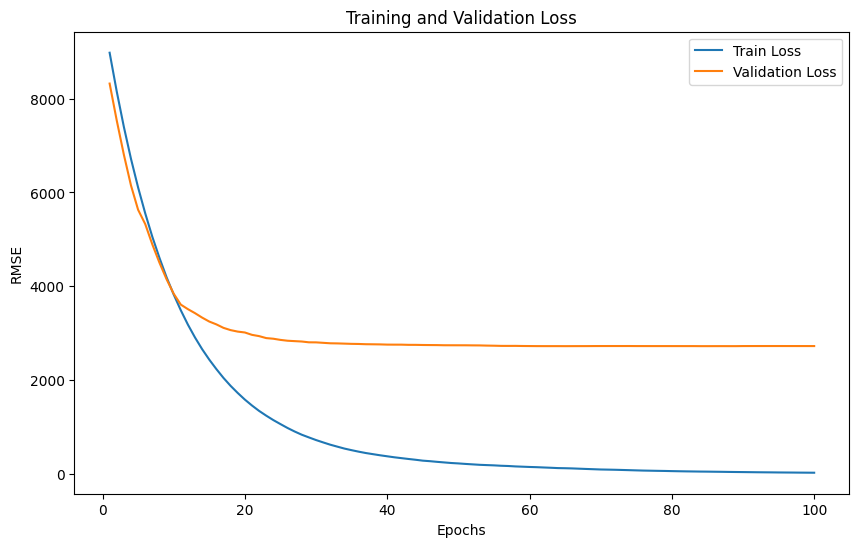

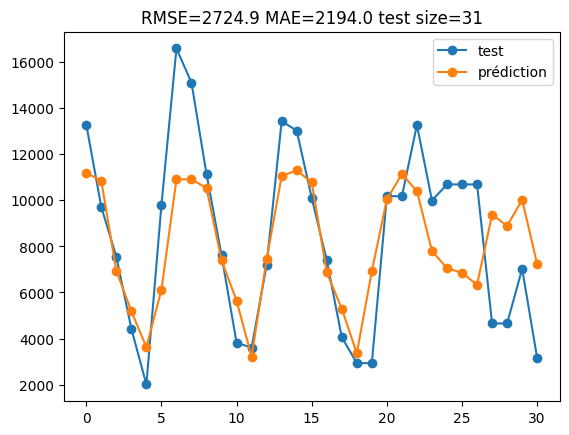

In [122]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100, random_state=42,eval_metric='rmse')

xg_reg.fit(X_train, Y_train,
               eval_set=[(X_train, Y_train), (X_test, Y_test)],verbose=False)

# Predict the labels of the test set
y_pred = xg_reg.predict(X_test)

# Calculate the mean squared error
rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
mae = mean_absolute_error(Y_test, y_pred)
print("RMSE:", rmse)
print("MAE:", mae)

plot_eval_result_XGBOOST(xg_reg.evals_result())
recursif(Y_test,y_pred,None,HOURLY)

In [123]:
options = Options(model_type=XGBOOST_TYPE,input_sequence_length=14,
        output_sequence_length=1,verbose_mod = 100, input_size=52)
col_names=list(x.columns) + list(y.columns)
len(col_names)
featureImportance(xg_reg,col_names)

AssertionError: Feature size calulated to be 728 but found 420

In [ ]:
param_space = {
    'n_estimators': np.arange(50, 300, 50),  # Number of boosting rounds
    'max_depth': np.arange(3, 10),  # Maximum depth of the tree
    'learning_rate': np.arange(0.01, 0.1, 0.02),  # Learning rate
    'subsample': np.arange(0.7, 1.0, 0.1),  # Subsample ratio
    'colsample_bytree': np.arange(0.7, 1.0, 0.1),  # Subsample ratio of columns
}
xgb_regressor = xgb.XGBRegressor(random_state=42,eval_metric=eval_metric)
# scoring can be ‘neg_mean_absolute_error’ or 'neg_mean_squared_error'
random_search = RandomizedSearchCV(xgb_regressor, param_distributions=param_space,
                                   n_iter=100, scoring=scoring_RCV, cv=3,
                                   random_state=42, verbose=1, n_jobs=-1)
random_search.fit(X_train, Y_train)

## getting best model stats

In [ ]:
best_model = random_search.best_estimator_
val_preds = best_model.predict(X_test)
val_rmse = np.sqrt(mean_squared_error(Y_test, val_preds))
val_mae = mean_absolute_error(Y_test, val_preds)
print('Validation MAE:', val_mae)
print('Validation RMSE:', val_rmse)
print('best params\n',random_search.best_params_)

best_model.fit(X_train, Y_train,
               eval_set=[(X_train, Y_train), (X_test, Y_test)],
               verbose=0)
eval_results = best_model.evals_result()
res = best_model.predict(X_test)
plot_eval_result_XGBOOST(eval_results)

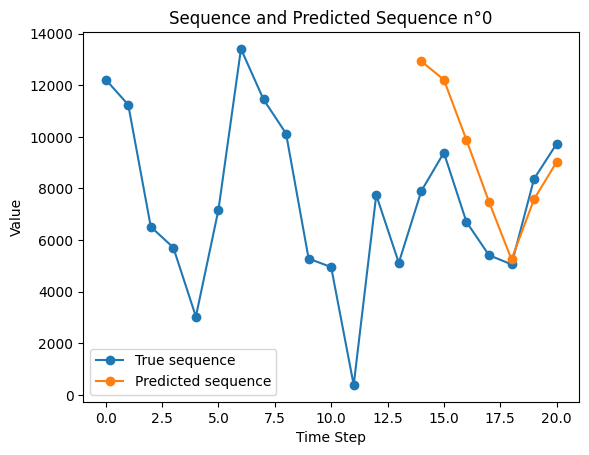

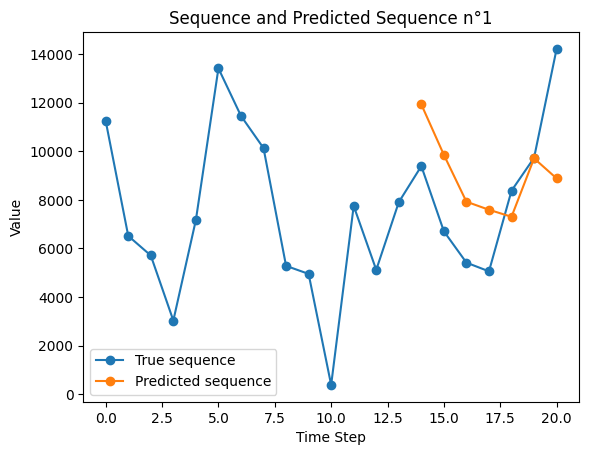

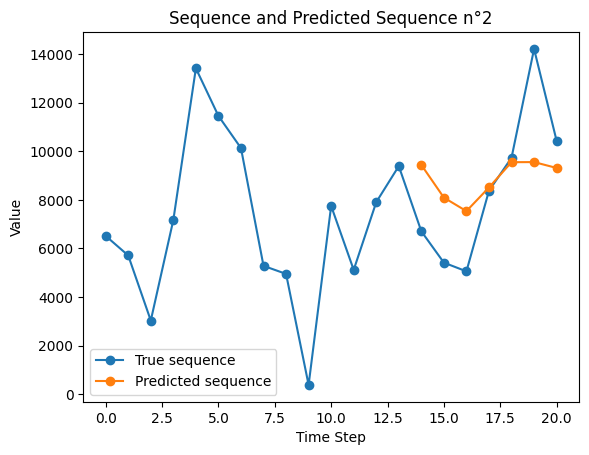

In [21]:
unflatten_X_test=np.array([x.reshape((14,28),order='F') for x in X_test])
show_test(unflatten_X_test,Y_test,res,input_sequence_length,output_sequence_length)

Best MAE validation: 2011.2135009765625
Best RMSE validation: 2559.43408203125
Best hyperparameters: {'max_depth': 5, 'learning_rate': 0.05939300189483214, 'subsample': 0.7677676796253867, 'colsample_bytree': 0.9439923071739449}


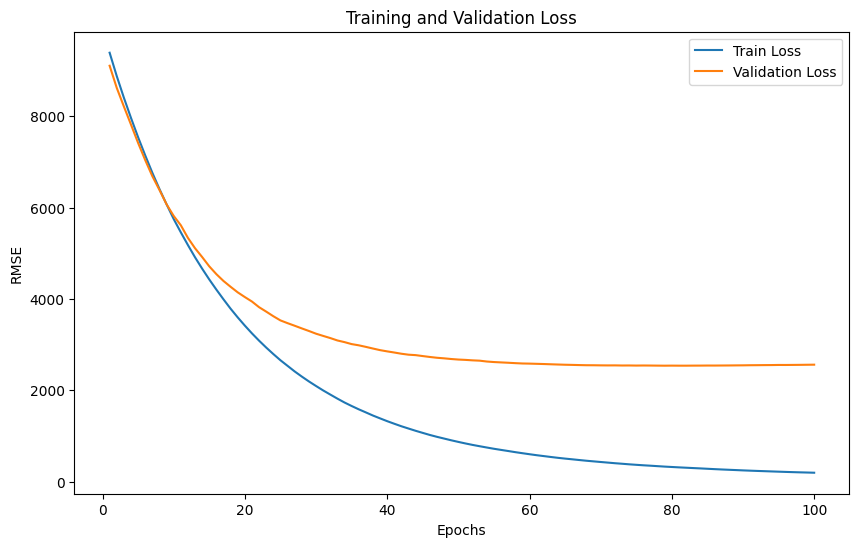

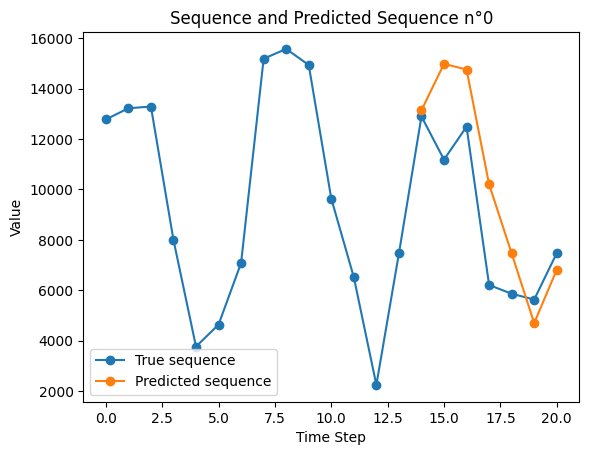

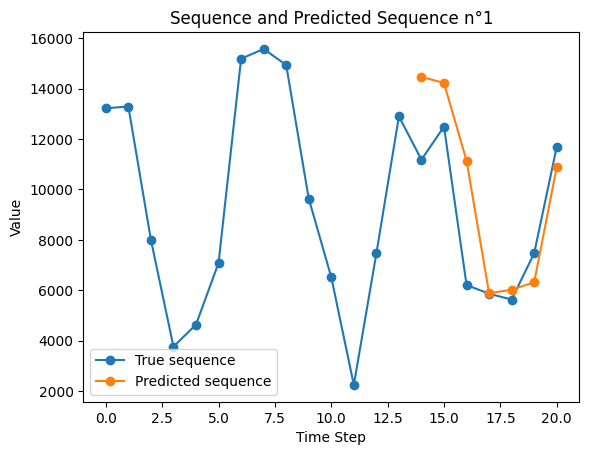

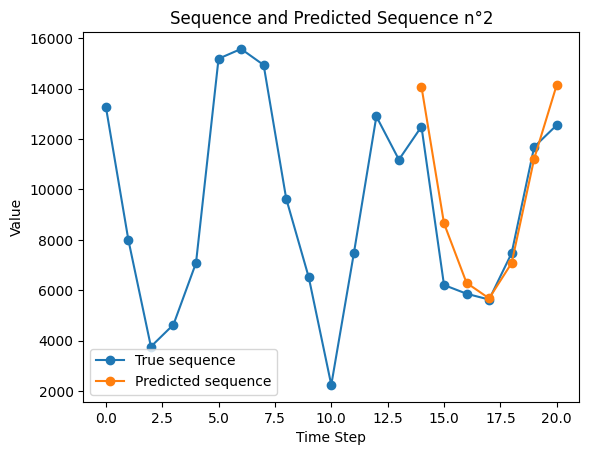

file saved at /Users/carlos/PycharmProjects/dionysos/prevision/results/Xgboost/saves/Xgboost_22.pkl


In [22]:
options = Options(model_type=XGBOOST_TYPE,input_sequence_length=input_sequence_length,
                      output_sequence_length=output_sequence_length,verbose_mod = 100, input_size=28)
a = Model(options)
b = DataLoader(options)
a.fineTuneXGBoostRay(b, None,100,scoring_Ray,eval_metric)

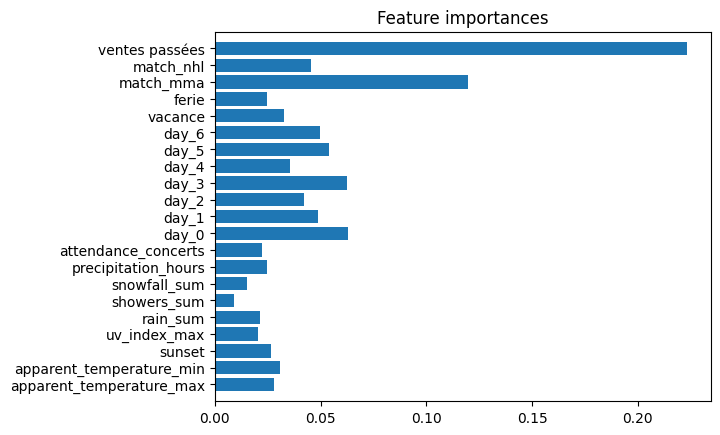

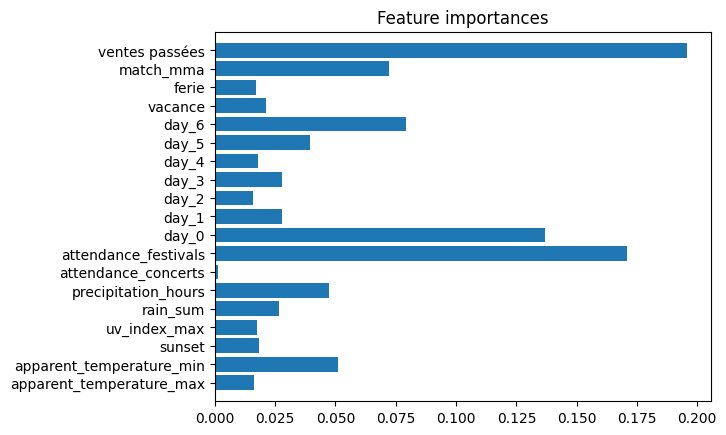

In [24]:
features_names=list(df_all.columns)+['ventes passées']
features_names.pop(0)
featureImportance(best_model,features_names)
featureImportance(a.model.model,features_names)

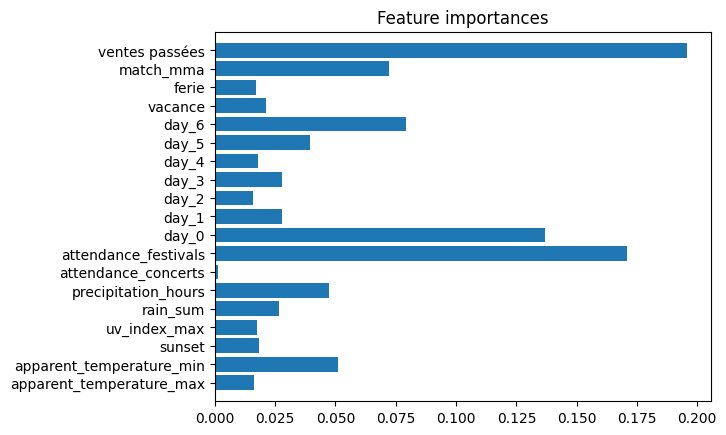

In [25]:
a.featureImportance(features_names)